# Импорты библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Градиентный бустинг над решающими деревьями для классификации

In [2]:
class GradientBoostingMachineClassifier:
    '''Метод-конструктор класса с базовыми начальными параметрами градиентного бустинга'''
    def __init__(self, learning_rate=0.025, n_estimators=1_000, logitboost=False, max_depth=8, random_state=69):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.logitboost = logitboost
        self.max_depth = max_depth
        self.random_state = random_state

    '''Метод, который вычисляет вероятности для каждого класса'''
    def _softmax(self, predictions):
        exp = np.exp(predictions)
        return exp / np.sum(exp, axis=1, keepdims=True)

    '''Метод для вычисления значений гамма для каждого листа дерева с использованием остатков'''
    def _compute_gammas(self, residuals, leaf_indexes, eps=1e-4):
        gammas = []
        for j in np.unique(leaf_indexes):
            x_i = np.where(leaf_indexes == j)
            numerator = np.sum(residuals[x_i])
            norm_residuals = np.linalg.norm(residuals[x_i]) + eps
            denominator = np.sum(norm_residuals*(1-norm_residuals))
            gamma = (self.K - 1)/self.K*numerator/denominator
            gammas.append(gamma)
        return gammas

    '''Метод для обучения модели'''
    def fit(self, X, y):
        self.feature_names = X.columns if hasattr(X, 'columns') else [f'Feature {i}' for i in range(X.shape[1])]
        self.K = len(np.unique(y))
        self.trees = {k: [] for k in range(self.K)}
        one_hot_y = pd.get_dummies(y).to_numpy()
        predictions = np.zeros(one_hot_y.shape)

        for _ in range(self.n_estimators):
            probabilities = self._softmax(predictions)
            for k in range(self.K):
                if self.logitboost:
                    numerator = (one_hot_y.T[k] - probabilities.T[k])
                    denominator = (probabilities.T[k]*(1-probabilities.T[k]))
                    residuals = (self.K-1).self.K*numerator/denominator
                    weight = denominator
                else:
                    residuals = one_hot_y.T[k] - probabilities.T[k]
                    weights = None

                tree = DecisionTreeRegressor(criterion='friedman_mse', max_depth=self.max_depth, random_state=self.random_state)
                tree.fit(X, residuals, sample_weight=weights)
                self.trees[k].append(tree)

                leaf_indexes = tree.apply(X)
                gammas = [] if self.logitboost else self._compute_gammas(residuals, leaf_indexes)
                predictions.T[k] += self.learning_rate*tree.predict(X) + np.sum(gammas)

    '''Метод для предсказания'''
    def predict(self, test):
        predictions = np.zeros((len(test), self.K))
        for i in range(self.n_estimators):
            for k in range(self.K):
                predictions.T[k] += self.learning_rate*self.trees[k][i].predict(test)
        return np.argmax(predictions, axis=1)


    '''Метод для отрисовки границ принятия решений для двумерных данных'''
    def plot_decision_boundaries(self, X, y):
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                             np.arange(y_min, y_max, 0.01))
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(('red', 'green', 'blue')))
        plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', marker='o', s=20, cmap=ListedColormap(('red', 'green', 'blue')))
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title('Decision Boundaries')
        plt.show()

    '''Метод который выводит важность признаков для заранее обученной модели'''
    def plot_feature_importance(self):
        feature_importances = np.zeros(self.trees[0][0].n_features_in_)
        for k in range(self.K):
            for tree in self.trees[k]:
                feature_importances += tree.feature_importances_
        feature_importances /= self.n_estimators * self.K

        sorted_idx = np.argsort(feature_importances)
        sorted_importances = feature_importances[sorted_idx]
        sorted_feature_names = np.array(self.feature_names)[sorted_idx]

        plt.figure(figsize=(10, 6))
        bars = plt.barh(sorted_feature_names, sorted_importances, color=plt.cm.viridis(np.linspace(0, 1, len(sorted_importances))))
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title('Feature Importance')
        plt.show()

In [3]:
class GradientBoostingMachineRegressor:
    '''Метод-конструктор класса с базовыми параметрами для бустинга'''
    def __init__(self, n_estimators=1_000, learning_rate=0.025, max_depth=8, random_state=69):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees = []

    '''Метод для обучения бустинга'''
    def fit(self, X, y):
        self.feature_names = X.columns if hasattr(X, 'columns') else [f'Feature {i}' for i in range(X.shape[1])]
        self.initial_leaf = y.mean()
        predictions = np.zeros(len(y)) + self.initial_leaf

        for _ in range(self.n_estimators):
            residuals = y - predictions
            tree = DecisionTreeRegressor(max_depth=self.max_depth, criterion='friedman_mse', random_state=self.random_state)
            tree.fit(X, residuals)
            predictions += tree.predict(X) * self.learning_rate
            self.trees.append(tree)

    '''Метод для предсказания'''
    def predict(self, test):
        predictions = np.zeros(len(test)) + self.initial_leaf

        for i in range(self.n_estimators):
            predictions += self.learning_rate * self.trees[i].predict(test)

        return predictions

    '''Метод, который выводит важность признаков для обученной модели'''
    def plot_feature_importance(self):
        feature_importances = np.zeros(self.trees[0].n_features_in_)
        for tree in self.trees:
            feature_importances += tree.feature_importances_
        feature_importances /= self.n_estimators

        sorted_idx = np.argsort(feature_importances)
        sorted_importances = feature_importances[sorted_idx]
        sorted_feature_names = np.array(self.feature_names)[sorted_idx]

        plt.figure(figsize=(24, 14))
        bars = plt.barh(sorted_feature_names, sorted_importances, color=plt.cm.viridis(np.linspace(0, 1, len(sorted_importances))))
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.title('Feature Importance')
        plt.show()

# Пример использования

In [4]:
# Загрузим данные и сделать тренировочную и тестовую выборки
X, y = load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=69, test_size=0.2)

In [5]:
# Определим модель и зададим ей начальный параметр количество деревьев
gbm_reg = GradientBoostingMachineRegressor(n_estimators=2_500)

In [6]:
# Обучаем модель
gbm_reg.fit(X_train, y_train)

In [7]:
# Измерим RMSE нашей модели на тестовых данных
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, gbm_reg.predict(X_test), squared=False)

57.498052585274806

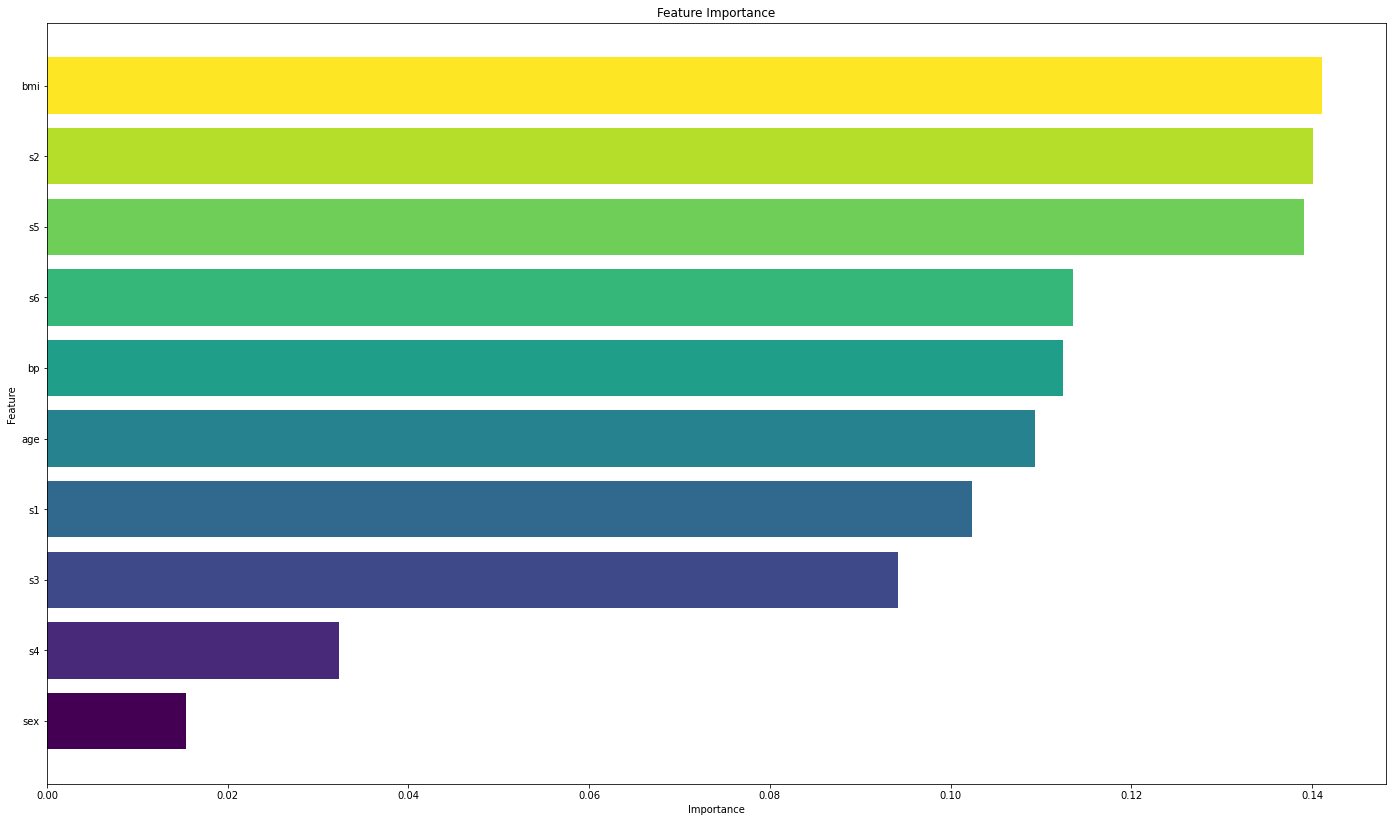

In [8]:
# Выведем важность фичей нашей модели
gbm_reg.plot_feature_importance()